In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from preprocessing_transformers import *

pd.set_option('display.max_columns', 100)

# Functions

Functions created to assist the preprocessing stage.

In [2]:
def show_correlation(columns, df):
    df_dummies = pd.get_dummies(df[columns])
    print((df_dummies
           .corr()[columns[0]]
           .to_frame()
           .dropna()
           .sort_values(by=columns[0], ascending=False)
           .mul(100)
           .round(2)
           ))

In [3]:
def plot_correlation(columns, df):
    plt.figure(figsize=(10, 5))
    sns.regplot(data=df, x=columns[0], y=columns[1], line_kws={'color':'red'})
    plt.title(f'{columns[0]} vs {columns[1]}', fontsize=15)
    plt.xlabel(columns[0], fontsize=12)
    plt.ylabel(columns[1], fontsize=12)
    plt.show()

In [4]:
def plot_num_column_distribution(column, df):
    plt.figure(figsize=(10, 5))
    k_sturges = int(1 + 3.322 * np.log10(len(df)))
    ax = sns.histplot(df[column], bins=k_sturges, kde=True)
    ax.xaxis.set_major_formatter('{x:.0f}')

    mean_price = df[column].mean()
    median_price = df[column].median()
    mode_price = df[column].mode()[0]

    plt.title(f'{column} Distribution', fontsize=15, pad=20)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.5)
    plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_price:,.0f}')
    plt.axvline(median_price, color='green', linestyle='-', linewidth=2, label=f'Median: {median_price:,.0f}')
    plt.axvline(mode_price, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_price:,.0f}')
    plt.legend()
    sns.despine()

    plt.show()

In [5]:
def show_columns_with_nan(df):
    print(df.isna().sum()[df.isna().sum() > 0])

In [6]:
def plot_boxplot(column, df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column], width=0.5)
    plt.title(f"{column} Boxplot", fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.show()

# 1. Load and Split the Training Data

I loaded the `train.csv` and divided it into **training** and **validation** sets.

In [7]:
train = pd.read_csv('data/train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [ ]:
# Unimportant column
train = train.drop(columns='Id')

To ensure a proportional distribution of 'SalePrice' values, I created a column to group the prices into categories.

In [9]:
train['PriceCategory'] = pd.qcut(train['SalePrice'], q=5, labels=False)
train['PriceCategory'].value_counts()

PriceCategory
3    295
0    295
1    294
4    289
2    287
Name: count, dtype: int64

In [10]:
train_train, train_test = train_test_split(train, stratify=train['PriceCategory'], test_size=0.2, random_state=42)

In [11]:
train_train['PriceCategory'].value_counts()

PriceCategory
0    236
3    236
1    235
4    231
2    230
Name: count, dtype: int64

In [12]:
train_test['PriceCategory'].value_counts()

PriceCategory
0    59
3    59
1    59
4    58
2    57
Name: count, dtype: int64

In [13]:
# The column created is no longer needed once the sets are proportionally distributed
train_train = train_train.drop(columns='PriceCategory')
train_test = train_test.drop(columns='PriceCategory')

In [16]:
train_train.to_csv('data/train_train.csv', index=False)
train_test.to_csv('data/train_test.csv', index=False)

I put the `train_test` aside until the model validation.

# 2. Check General Information

In [17]:
df = train_train.copy()
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
307,50,RM,NaN,7920,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,6,7,1920,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Fa,CBlock,TA,TA,No,Unf,0,Unf,0,319,319,GasA,TA,Y,FuseA,1035,371,0,1406,0,0,1,0,3,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,144,0,0,0,0,NaN,MnPrv,NaN,0,3,2008,WD,Normal,89500
1341,20,RL,66.0,13695,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,RRAe,Norm,1Fam,1Story,6,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,814,Unf,0,300,1114,GasA,Ex,Y,SBrkr,1114,0,0,1114,1,0,1,0,3,1,Gd,6,Typ,0,NaN,Detchd,2004.0,Unf,2,576,TA,TA,Y,0,78,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,155000
1175,50,RL,85.0,10678,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1.5Fin,8,5,1992,2000,Hip,CompShg,HdBoard,HdBoard,BrkFace,337.0,Gd,TA,PConc,Gd,TA,No,GLQ,700,Unf,0,983,1683,GasA,Ex,Y,SBrkr,2129,743,0,2872,0,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,1992.0,Fin,2,541,TA,TA,Y,0,33,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,285000
349,60,RL,56.0,20431,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,BrkFace,870.0,Ex,TA,PConc,Ex,TA,No,GLQ,1410,Unf,0,438,1848,GasA,Ex,Y,SBrkr,1848,880,0,2728,1,0,2,1,4,1,Ex,10,Typ,2,Ex,Attchd,2006.0,Fin,3,706,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2006,New,Partial,437154
621,60,RL,90.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,7,1974,1997,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,956,Rec,182,384,1522,GasA,TA,Y,SBrkr,1548,1066,0,2614,0,0,2,1,4,1,TA,9,Typ,1,TA,Attchd,1974.0,RFn,2,624,TA,TA,Y,38,243,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,20,RL,NaN,9477,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1966,1966,Gable,CompShg,HdBoard,HdBoard,BrkFace,65.0,TA,TA,CBlock,TA,TA,No,Rec,340,Unf,0,524,864,GasA,TA,Y,SBrkr,892,0,0,892,0,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1966.0,RFn,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,10,2008,WD,Normal,110000
389,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,10,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,272.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1280,Unf,0,402,1682,GasA,Ex,Y,SBrkr,1742,590,0,2332,1,0,2,1,3,1,Ex,9,Typ,1,Ex,BuiltIn,2008.0,Fin,3,846,TA,TA,Y,196,134,0,0,0,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
1323,30,RL,50.0,5330,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,4,7,1940,1950,Hip,CompShg,VinylSd,VinylSd,NaN,0.0,Fa,TA,CBlock,TA,TA,No,LwQ,280,Unf,0,140,420,GasA,Gd,Y,SBrkr,708,0,0,708,0,0,1,0,2,1,Fa,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,164,0,0,0,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal,82500
33,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1959,1959,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,1018,Unf,0,380,1398,GasA,Gd,Y,SBrkr,1700,0,0,1700,0,1,1,1,4,1,Gd,6

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 307 to 190
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    957 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          70 non-null     object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuilt   

In [19]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [20]:
show_columns_with_nan(df)

LotFrontage      211
Alley           1098
MasVnrType       707
MasVnrArea         8
BsmtQual          31
BsmtCond          31
BsmtExposure      31
BsmtFinType1      31
BsmtFinType2      32
Electrical         1
FireplaceQu      562
GarageType        63
GarageYrBlt       63
GarageFinish      63
GarageQual        63
GarageCond        63
PoolQC          1162
Fence            940
MiscFeature     1127
dtype: int64


In [21]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,957.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1160.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1105.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.314212,70.453501,10485.791096,6.093322,5.583904,1971.005137,1984.967466,102.805172,437.226027,49.244007,574.291952,1060.761986,1167.609589,342.747432,6.369863,1516.726884,0.424658,0.055651,1.560788,0.376712,2.861301,1.046233,6.529110,0.603596,1978.387330,1.773973,472.837329,91.192637,47.301370,22.886130,3.883562,15.446062,3.037671,48.599315,6.237158,2007.843322,182256.590753
std,41.688420,23.535364,9281.751411,1.401073,1.137420,30.222454,20.883665,183.902903,435.973974,167.331395,453.609301,430.045993,386.283434,438.791341,50.714215,528.250544,0.513210,0.233050,0.559780,0.502135,0.833906,0.214119,1.635879,0.644976,24.965052,0.748794,213.685093,123.880812,66.938562,61.760365,31.899534,56.767891,42.672869,551.868466,2.686299,1.337716,82226.369737
min,20.000000,21.000000,1477.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7500.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,796.000000,884.000000,0.000000,0.000000,1120.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,326.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9485.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,378.500000,0.000000,482.500000,992.000000,1088.000000,0.000000,0.000000,1465.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11769.500000,7.000000,6.000000,2000.250000,2004.000000,160.250000,705.250000,0.000000,814.500000,1304.000000,1396.000000,728.000000,0.000000,1776.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4676.000000,2.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**describe() - Insights**
- 'MSSubClass' appears to be nominal categorical.
- 'LotArea' and 'MasVnrArea' seem to have outliers.

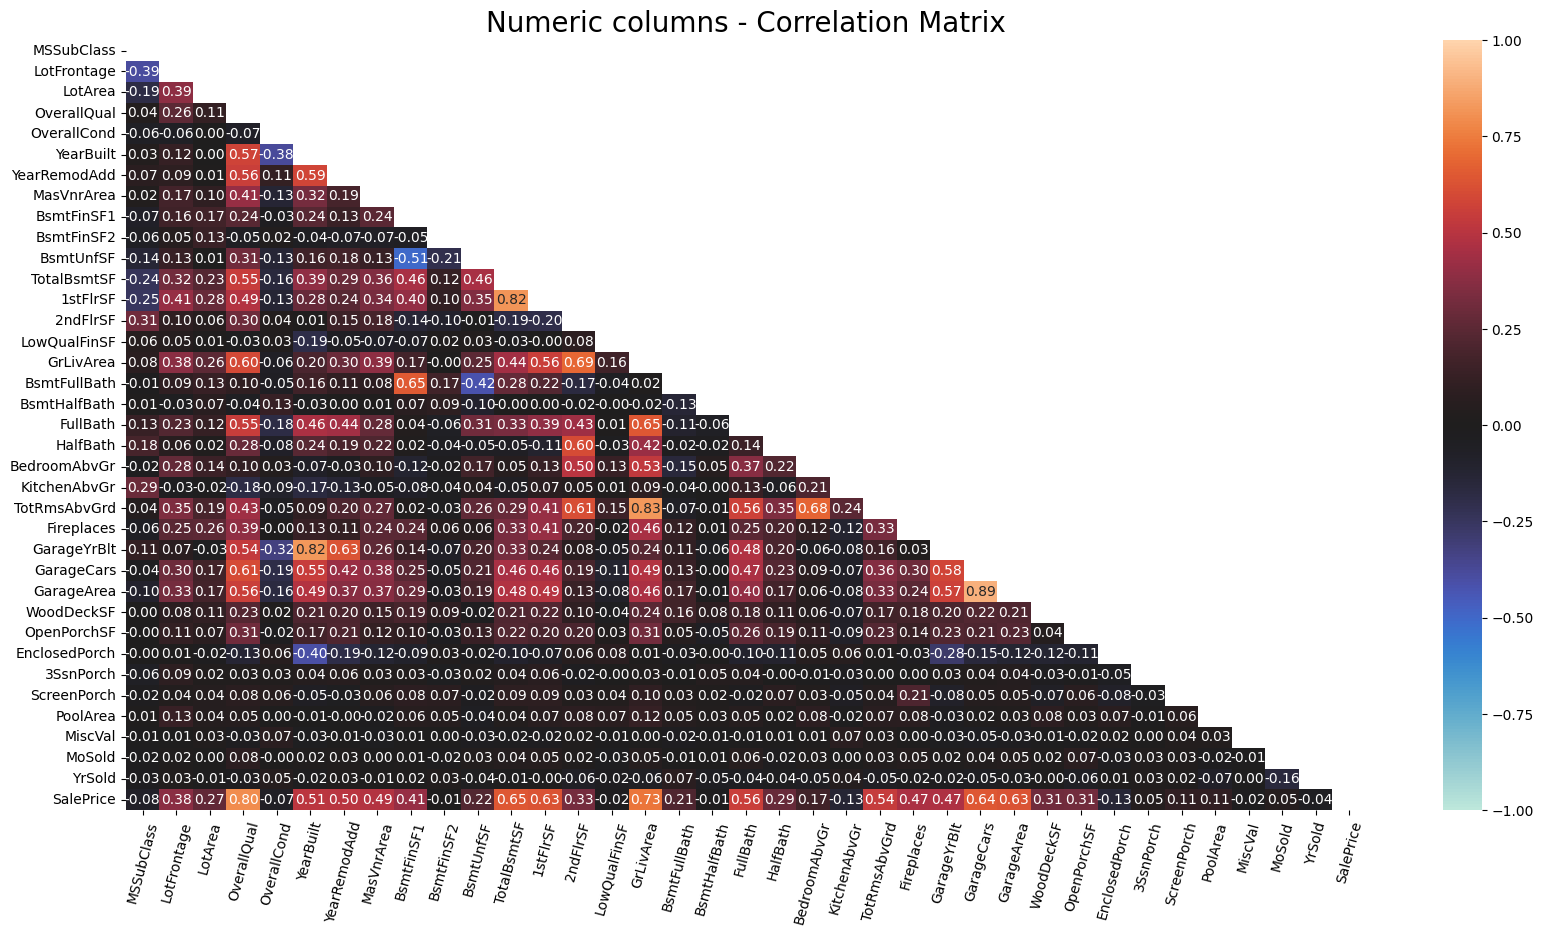

In [22]:
df_corr = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(20, 10))
sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap="icefire", vmin=-1, vmax=1)
plt.title('Numeric columns - Correlation Matrix', fontsize=20)
plt.xticks(rotation=75)

plt.show()

**Correlation Matrix - Insights**
- 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', and 'MiscVal' have very low correlation with 'SalePrice'. I may drop them after further analyses.
- 'GarageArea' and 'GarageCars' are highly correlated. I can drop the one less correlated to 'SalePrice' or combine them and drop both.

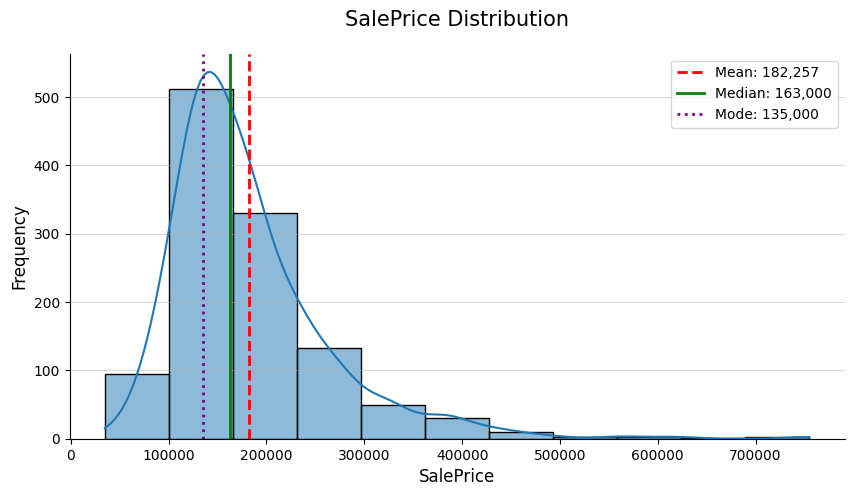

In [23]:
plot_num_column_distribution('SalePrice', df)

Right-skewed distribution.

In [24]:
df.duplicated().sum()

np.int64(0)

# 3. Handle Missing Values

In [25]:
show_columns_with_nan(df)

LotFrontage      211
Alley           1098
MasVnrType       707
MasVnrArea         8
BsmtQual          31
BsmtCond          31
BsmtExposure      31
BsmtFinType1      31
BsmtFinType2      32
Electrical         1
FireplaceQu      562
GarageType        63
GarageYrBlt       63
GarageFinish      63
GarageQual        63
GarageCond        63
PoolQC          1162
Fence            940
MiscFeature     1127
dtype: int64


Some columns have "false" and "true" missing values, because according to `data_description` some columns have NaN, but they actually mean something. So I handled both of them.

## 3.1 False missing values

### Alley
NaN = No alley access

The column may have true missing values, but I couldn't find any column that was somehow correlated with 'Alley', such as "AlleySF". So I filled all missing values with 'None'.

In [26]:
# False missing values
df['Alley'] = df['Alley'].fillna('None')
show_columns_with_nan(df)

LotFrontage      211
MasVnrType       707
MasVnrArea         8
BsmtQual          31
BsmtCond          31
BsmtExposure      31
BsmtFinType1      31
BsmtFinType2      32
Electrical         1
FireplaceQu      562
GarageType        63
GarageYrBlt       63
GarageFinish      63
GarageQual        63
GarageCond        63
PoolQC          1162
Fence            940
MiscFeature     1127
dtype: int64


### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
NaN = No Basement

All columns have 31 NaN values, except for 'BsmtFinType2' that has 32, it has one true missing value, but I also filled it with 'None'.

In [27]:
# False missing values
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[column] = df[column].fillna('None')
show_columns_with_nan(df)

LotFrontage      211
MasVnrType       707
MasVnrArea         8
Electrical         1
FireplaceQu      562
GarageType        63
GarageYrBlt       63
GarageFinish      63
GarageQual        63
GarageCond        63
PoolQC          1162
Fence            940
MiscFeature     1127
dtype: int64


### FireplaceQu
NaN = No Fireplace

There is another column 'Fireplaces', which indicates the number of fireplaces in the house. I checked if the number of houses where Fireplaces == 0 equals the number of NaN values in 'FireplaceQu'.

In [28]:
print(f"Number of houses 'Fireplaces == 0': {df.query('Fireplaces == 0').shape[0]}")
print(f"NaN values in 'FireplaceQu': {df['FireplaceQu'].isna().sum()}")

Number of houses 'Fireplaces == 0': 562
NaN values in 'FireplaceQu': 562


The values are equal, so there are no true missing values in 'FireplaceQu'.

In [29]:
# False missing values
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
show_columns_with_nan(df)

LotFrontage      211
MasVnrType       707
MasVnrArea         8
Electrical         1
GarageType        63
GarageYrBlt       63
GarageFinish      63
GarageQual        63
GarageCond        63
PoolQC          1162
Fence            940
MiscFeature     1127
dtype: int64


### GarageType, GarageFinish, GarageQual, GarageCond
NaN	= No Garage

The same process as I did with 'Bsmts'.

All columns have 63 NaN values. No true missing values.

In [30]:
# False missing values
for column in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[column] = df[column].fillna('None')
show_columns_with_nan(df)

LotFrontage     211
MasVnrType      707
MasVnrArea        8
Electrical        1
GarageYrBlt      63
PoolQC         1162
Fence           940
MiscFeature    1127
dtype: int64


### PoolQC
NaN = No Pool

The same process as I did in 'FireplaceQu'.

In [31]:
print(f"Number of houses 'PoolArea == 0': {df.query('PoolArea == 0').shape[0]}")
print(f"NaN values in 'PoolQC': {df['PoolQC'].isna().sum()}")

Number of houses 'PoolArea == 0': 1162
NaN values in 'PoolQC': 1162


No true missing values.

In [32]:
# False missing values
df['PoolQC'] = df['PoolQC'].fillna('None')
show_columns_with_nan(df)

LotFrontage     211
MasVnrType      707
MasVnrArea        8
Electrical        1
GarageYrBlt      63
Fence           940
MiscFeature    1127
dtype: int64


### Fence
NaN = No Fence

Since this column has no correlated features, such as 'FenceHeight', I filled it with 'None'.

In [33]:
# False missing values
df['Fence'] = df['Fence'].fillna("None")
show_columns_with_nan(df)

LotFrontage     211
MasVnrType      707
MasVnrArea        8
Electrical        1
GarageYrBlt      63
MiscFeature    1127
dtype: int64


### MiscFeature
NaN = None

In [34]:
print(f"Number of houses 'MiscVal == 0': {df.query('MiscVal == 0').shape[0]}")
print(f"NaN values in 'MiscFeature': {df['MiscFeature'].isna().sum()}")

Number of houses 'MiscVal == 0': 1129
NaN values in 'MiscFeature': 1127


In [35]:
# False missing values
df['MiscFeature'] = df['MiscFeature'].fillna('None')
show_columns_with_nan(df)

LotFrontage    211
MasVnrType     707
MasVnrArea       8
Electrical       1
GarageYrBlt     63
dtype: int64


---
**Testing -preprocessing_transformers.py-**

I created a Python file to replicate all the processes I performed and build a customized pipeline for preprocessing.

In [ ]:
# Check if the processes performed here is same as the ones created in the Python file
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

## 3.2 True missing values

In [38]:
show_columns_with_nan(df)

LotFrontage    211
MasVnrType     707
MasVnrArea       8
Electrical       1
GarageYrBlt     63
dtype: int64


In `data_description`, these columns don't specify that NaN values mean "None" or something.

### LotFrontage
Linear feet of street connected to property.

In [39]:
show_correlation(['SalePrice', 'LotFrontage'], df)

             SalePrice
SalePrice       100.00
LotFrontage      37.93


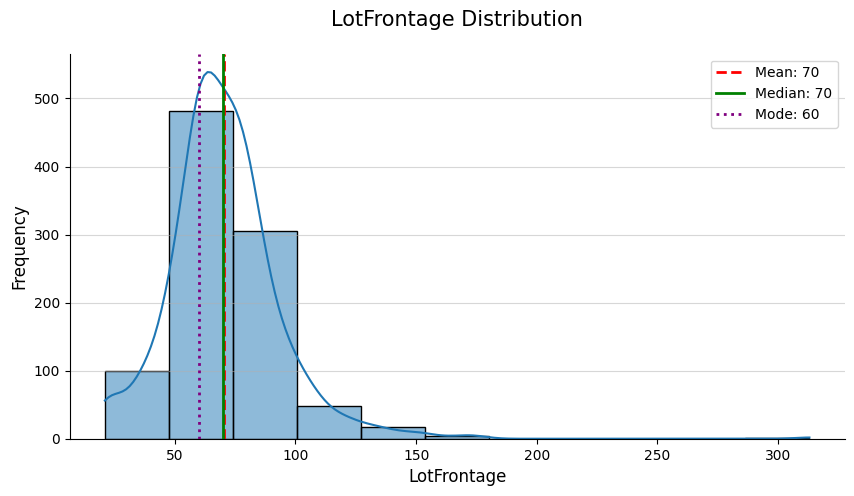

In [40]:
plot_num_column_distribution('LotFrontage', df)

Right-skewed distribution.

I tried to find some columns that have high correlation with 'LotFrontage'.

In [41]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [42]:
show_correlation(['LotFrontage', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'], df)

                   LotFrontage
LotFrontage             100.00
1stFlrSF                 40.83
BldgType_1Fam            40.38
LotArea                  39.01
SalePrice                37.93
...                        ...
GarageType_Detchd       -26.78
MSZoning_RM             -32.98
BldgType_Twnhs          -33.89
BldgType_TwnhsE         -34.16
MSSubClass              -38.81

[289 rows x 1 columns]


No column with high correlation. So I checked the lowest value in the column.

In [43]:
df['LotFrontage'].min()

np.float64(21.0)

It appears that missing values in 'LotFrontage' correspond to 'LotFrontage == 0'. So I checked it.

In [44]:
df_2 = df.copy()
df_2['LotFrontage'] = df_2['LotFrontage'].fillna(0)
show_correlation(['SalePrice', 'LotFrontage'], df_2)

             SalePrice
SalePrice       100.00
LotFrontage      23.23


The correlation between 'LotFrontage' and 'SalePrice' decreased, the NaN values doesn't mean 'LotFrontage == 0'. So I filled it with the median.

In [45]:
# True missing values
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
show_columns_with_nan(df)

MasVnrType     707
MasVnrArea       8
Electrical       1
GarageYrBlt     63
dtype: int64


In [46]:
show_correlation(['SalePrice', 'LotFrontage'], df)

             SalePrice
SalePrice       100.00
LotFrontage      36.17


### MasVnrType
Masonry veneer type.

In [47]:
show_correlation(['SalePrice', 'MasVnrType'], df)

                    SalePrice
SalePrice              100.00
MasVnrType_Stone        33.77
MasVnrType_BrkFace      18.71
MasVnrType_BrkCmn       -4.63


2 more types of 'MasVnrType' are missing, according to the `data_description`: *CBlock* and *None*. <br>

#### *None*
For *None* I checked rows that have MasVnrArea == 0 and filled these rows. <br>

In [48]:
# True missing values
indexes_MasVnrArea_0 = df.query("MasVnrArea == 0").index
df.loc[indexes_MasVnrArea_0, 'MasVnrType'] = df.loc[indexes_MasVnrArea_0, 'MasVnrType'].fillna('None')
show_columns_with_nan(df)

MasVnrType     13
MasVnrArea      8
Electrical      1
GarageYrBlt    63
dtype: int64


#### *CBlock*
Only 13 null values remain for *CBlock*.

In [49]:
# True missing values
df['MasVnrType'] = df['MasVnrType'].fillna('CBlock')
show_columns_with_nan(df)

MasVnrArea      8
Electrical      1
GarageYrBlt    63
dtype: int64


In [50]:
show_correlation(['SalePrice', 'MasVnrType'], df)

                    SalePrice
SalePrice              100.00
MasVnrType_Stone        33.77
MasVnrType_BrkFace      18.71
MasVnrType_CBlock        3.40
MasVnrType_BrkCmn       -4.63
MasVnrType_None        -36.57


### MasVnrArea
Masonry veneer area in square feet.

Only 8 missing values, so I filled it with the median.

In [51]:
show_correlation(['SalePrice', 'MasVnrArea'], df)

            SalePrice
SalePrice       100.0
MasVnrArea       48.8


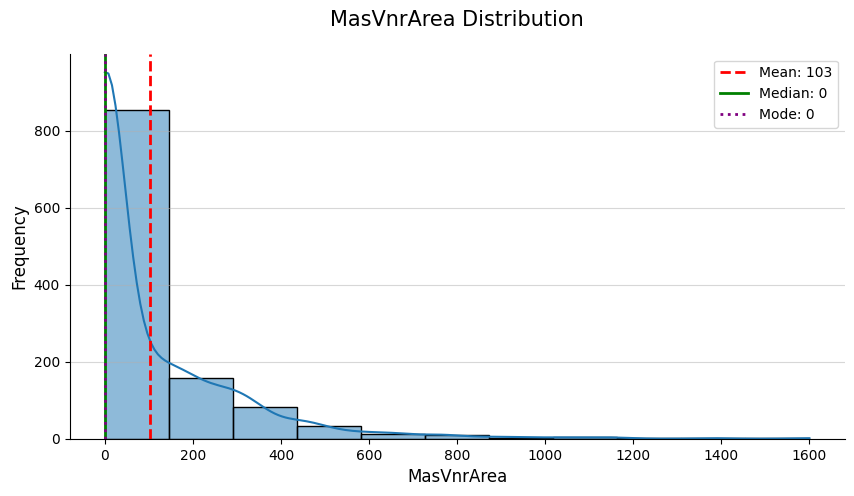

In [52]:
plot_num_column_distribution('MasVnrArea', df)

Right-skewed distribution.

In [53]:
# True missing values
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
show_columns_with_nan(df)

Electrical      1
GarageYrBlt    63
dtype: int64


In [54]:
show_correlation(['SalePrice', 'MasVnrArea'], df)

            SalePrice
SalePrice      100.00
MasVnrArea      48.23


### Electrical
Electrical system.

Only 1 missing values, I filled it with the mode.

In [55]:
show_correlation(['SalePrice', 'Electrical'], df)

                  SalePrice
SalePrice            100.00
Electrical_SBrkr      24.52
Electrical_FuseP      -3.57
Electrical_Mix        -4.10
Electrical_FuseF     -14.13
Electrical_FuseA     -19.04


In [56]:
# True missing values
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
show_columns_with_nan(df)

GarageYrBlt    63
dtype: int64


In [57]:
show_correlation(['SalePrice', 'Electrical'], df)

                  SalePrice
SalePrice            100.00
Electrical_SBrkr      24.57
Electrical_FuseP      -3.57
Electrical_Mix        -4.10
Electrical_FuseF     -14.13
Electrical_FuseA     -19.04


### GarageYrBlt
Year garage was built.

In [58]:
show_correlation(['SalePrice', 'GarageYrBlt'], df)

             SalePrice
SalePrice       100.00
GarageYrBlt      47.27


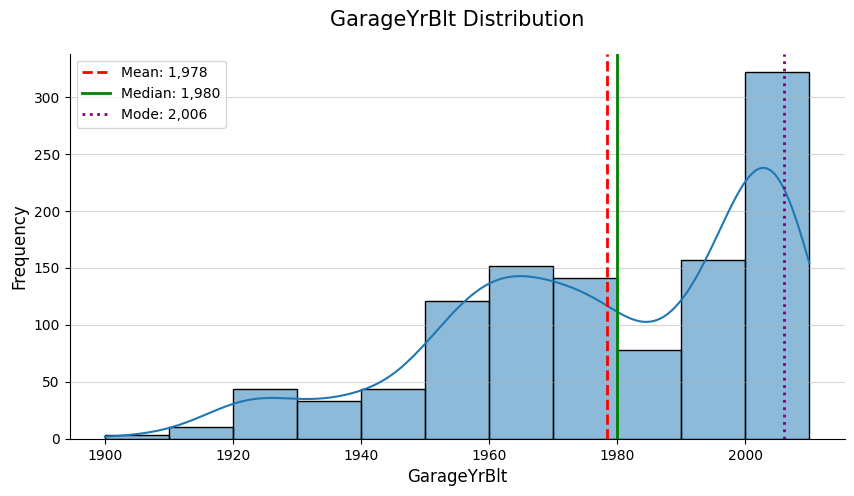

In [59]:
plot_num_column_distribution('GarageYrBlt', df)

Left-skewed distribution.

'GarageArea == 0' may have correlation with NaN values in 'GarageYrBlt'.

In [60]:
indexes_GarageArea_0 = df.query("GarageArea == 0").index
df.loc[indexes_GarageArea_0]['GarageYrBlt'].unique()

array([nan])

When 'GarageArea == 0', it indeed implies that 'GarageYrBlt == NaN'. So I checked if the values were equal.

In [61]:
print(f"Number of houses 'GarageArea == 0': {df.query('GarageArea == 0').shape[0]}")
print(f"NaN values in 'GarageYrBlt': {df['GarageYrBlt'].isna().sum()}")

Number of houses 'GarageArea == 0': 63
NaN values in 'GarageYrBlt': 63


The values are equal, so the houses with NaN 'GarageYrBlt' are the ones that don't have garage. I filled the NaN values with the 'YearBuilt' of the house.

In [62]:
# True missing values
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"])
show_columns_with_nan(df)

Series([], dtype: int64)


In [63]:
show_correlation(['SalePrice', 'GarageYrBlt'], df)

             SalePrice
SalePrice       100.00
GarageYrBlt      49.65


No more missing values to handle.

---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

# 4. Handle Outliers

I handled those that I considered outliers during **2. Check General Information**: 'LotArea' and 'MasVnrArea'.

## LotArea
Lot size in square feet.

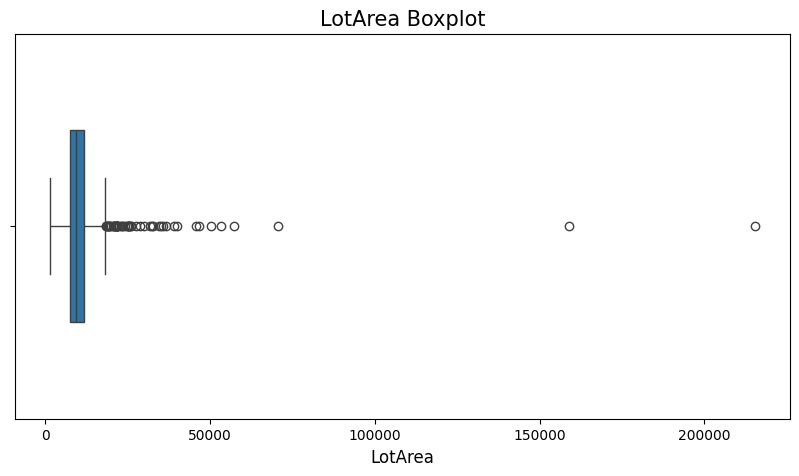

In [66]:
plot_boxplot('LotArea', df)

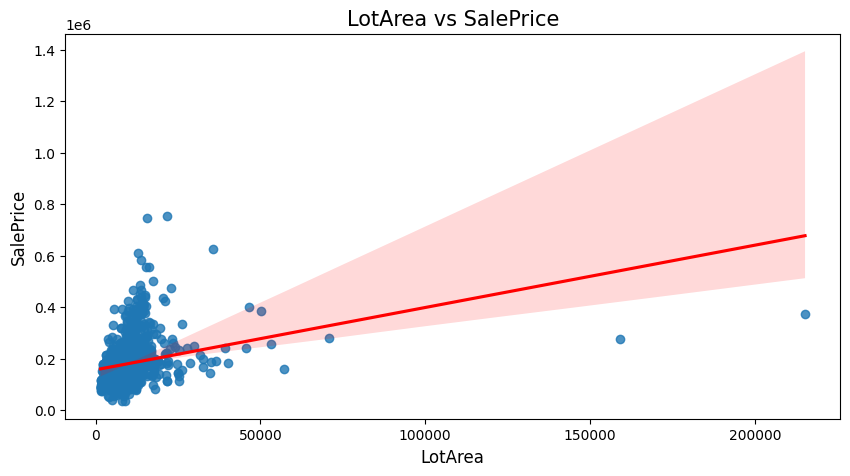

In [67]:
plot_correlation(['LotArea', 'SalePrice'], df)

The houses with a larger 'LotArea' don't have higher 'SalePrice', which suggests to me that the high values are outliers.

In [68]:
show_correlation(['SalePrice', 'LotArea'], df)

           SalePrice
SalePrice      100.0
LotArea         27.3


I applied the interquartile range (IQR) method to detect and limit outliers in 'LotArea'. Values ​​below **(Q1 - 1.5 * IQR)** or above **(Q3 + 1.5 * IQR)** were trimmed using np.clip(), ensuring they remain within the range.

In [69]:
# Outliers
Q1 = df['LotArea'].quantile(0.25)
Q3 = df['LotArea'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['LotArea'] = np.clip(df['LotArea'], lower_bound, upper_bound)
    
show_correlation(['SalePrice', 'LotArea'], df)

           SalePrice
SalePrice     100.00
LotArea        43.37


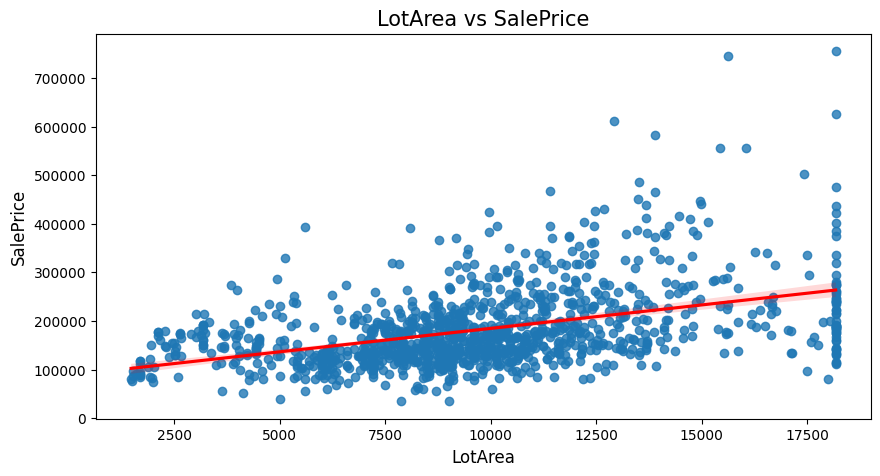

In [70]:
plot_correlation(['LotArea', 'SalePrice'], df)

## 'MasVnrArea'
Masonry veneer area in square feet.

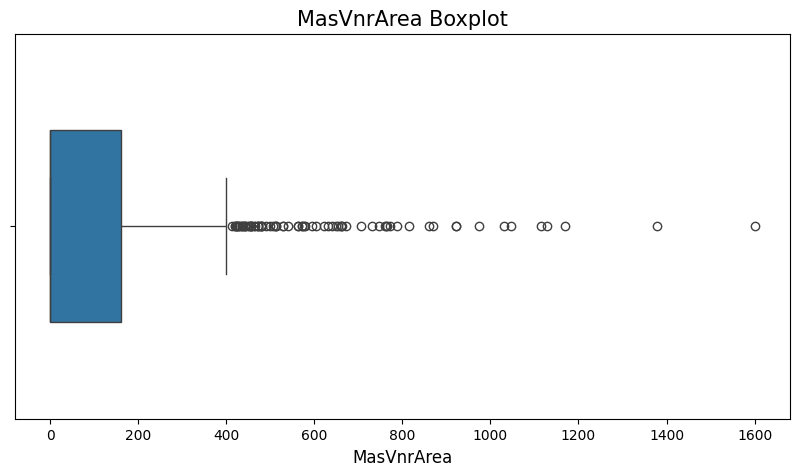

In [71]:
plot_boxplot('MasVnrArea', df)

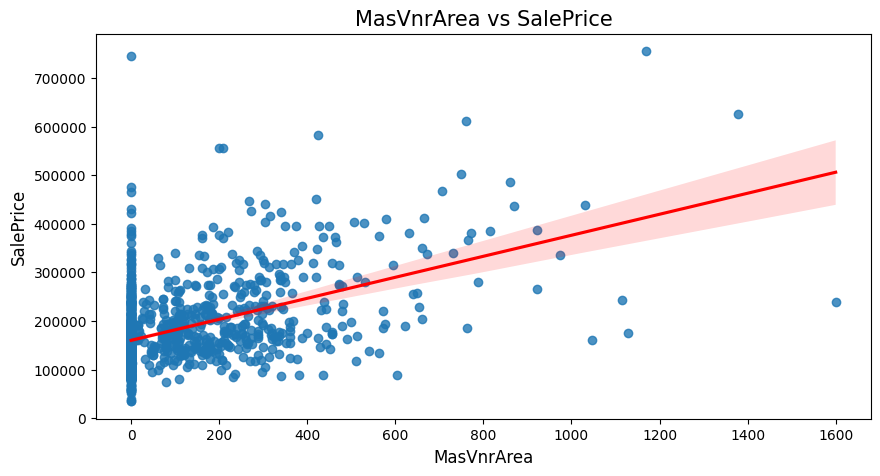

In [72]:
plot_correlation(['MasVnrArea', 'SalePrice'], df)

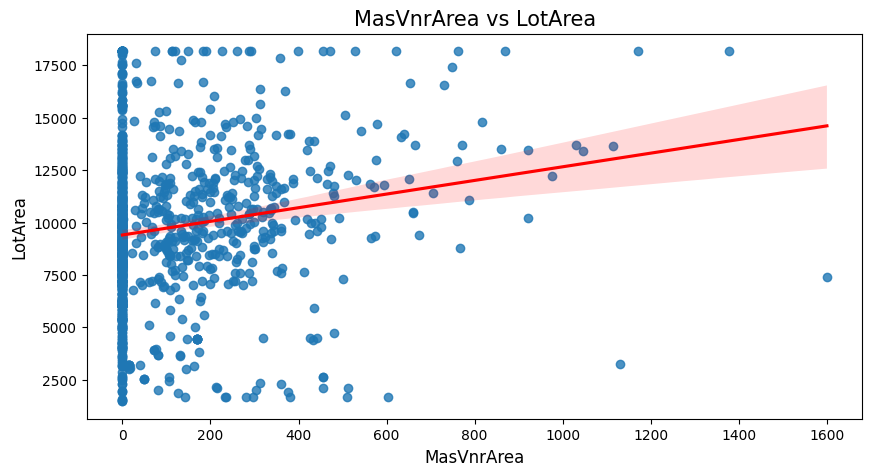

In [73]:
plot_correlation(['MasVnrArea', 'LotArea'], df)

It is expected that the higher the 'MasVnrArea' the higher is the 'LotArea', when 'MasVnrArea > 600' we can see that trend. So I didn't consider this column with outliers.

---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

# 5. Feature Engineering

## 'GarageAreaCars'
As analyzed in **2. Check General Information**, 'GarageArea' and 'GarageCars' are highly correlated. I combined them in the most effective way according to correlation with 'SalePrice' and then dropped both.

In [ ]:
# Feature engineering
df['GarageAreaCars'] = df['GarageArea'] * df['GarageCars']
show_correlation(['SalePrice', 'GarageArea', 'GarageCars', 'GarageAreaCars'], df)

                SalePrice
SalePrice          100.00
GarageAreaCars      67.81
GarageCars          64.15
GarageArea          62.50


In [ ]:
df = df.drop(columns=['GarageArea', 'GarageCars'])

## 'BsmtFinSF' - Basement Finished Square Feet
It contains the 'TotalBsmtSF' minus 'BsmtUnfSF'.

In [76]:
# Feature engineering
df['BsmtFinSF'] = df['TotalBsmtSF'] - df['BsmtUnfSF']
show_correlation(['SalePrice', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF'], df)

             SalePrice
SalePrice       100.00
TotalBsmtSF      64.57
BsmtFinSF        38.52
BsmtUnfSF        22.21


## 'HighQualFinSF' - High Quality Finished Square Feet
It contains the sum of '1stFlrSF', '2ndFlrSF' and 'TotalBsmtSF' minus 'LowQualFinSF'.

In [77]:
# Feature engineering
df['HighQualFinSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF'] - df['LowQualFinSF']
show_correlation(['SalePrice', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LowQualFinSF', 'HighQualFinSF'], df)

               SalePrice
SalePrice         100.00
HighQualFinSF      81.91
TotalBsmtSF        64.57
1stFlrSF           63.12
2ndFlrSF           32.57
LowQualFinSF       -1.86


## 'TotalBathrooms'
It contains the sum of full/half bathrooms.

In [78]:
# Feature engineering
df['TotalBathrooms'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']
show_correlation(['SalePrice', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBathrooms'], df)

                SalePrice
SalePrice          100.00
TotalBathrooms      61.51
FullBath            55.86
HalfBath            28.72
BsmtFullBath        21.18
BsmtHalfBath        -1.07


## 'TotalPorch'
It contains the sum of all porches.

In [82]:
# Feature engineering
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
show_correlation(['SalePrice', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'TotalPorch'], df)

               SalePrice
SalePrice         100.00
OpenPorchSF        31.44
TotalPorch         19.30
ScreenPorch        10.88
3SsnPorch           4.62
EnclosedPorch     -13.45


## 'OverallAvg'
It contains the average of 'OverallQual' and 'OverallCond'.

In [83]:
# Feature engineering
df['OverallAvg'] = (df['OverallQual'] + df['OverallCond']) / 2
show_correlation(['SalePrice', 'OverallQual', 'OverallCond', 'OverallAvg'], df)

             SalePrice
SalePrice       100.00
OverallQual      79.68
OverallAvg       59.89
OverallCond      -6.57


## 'TotalInternalArea'
It contains the combined area of the floors and the basement.

In [84]:
# Feature engineering
df['TotalInternalArea'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
show_correlation(['SalePrice', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'TotalInternalArea'], df)

                   SalePrice
SalePrice             100.00
TotalInternalArea      81.81
TotalBsmtSF            64.57
1stFlrSF               63.12
2ndFlrSF               32.57


## 'ApproxExternalArea'
It contains the approximate external area with 'LotArea' minus '1stFlrSF'.

In [85]:
# Feature engineering
df['ApproxExternalArea'] = df['LotArea'] - df['1stFlrSF']
show_correlation(['SalePrice', 'LotArea', '1stFlrSF', 'ApproxExternalArea'], df)

                    SalePrice
SalePrice              100.00
1stFlrSF                63.12
LotArea                 43.37
ApproxExternalArea      38.39


## 'Age'
It contains the 'YearBuilt' minus 2010 (the most recent year in the dataset).

In [86]:
df['Age'] = 2010 - df['YearBuilt']
show_correlation(['SalePrice', 'YearBuilt', 'Age'], df)

           SalePrice
SalePrice     100.00
YearBuilt      51.03
Age           -51.03


In [87]:
show_correlation(['YearBuilt', 'Age'], df)

           YearBuilt
YearBuilt      100.0
Age           -100.0


The columns are the same, so I dropped 'Age'.

In [88]:
df = df.drop(columns='Age')

## 'AgeWhenSold'
It contains the time when the house was sold.

In [ ]:
# Feature engineering
df['AgeWhenSold'] = df['YrSold'] - df['YearBuilt']
show_correlation(['SalePrice', 'YrSold', 'YearBuilt', 'AgeWhenSold'], df)

             SalePrice
SalePrice       100.00
YearBuilt        51.03
YrSold           -4.14
AgeWhenSold     -51.12


## 'YearsUntilRemodel'
It contains the 'YearRemodAdd' minus 'YearBuilt'.

In [90]:
# Feature engineering
df['YearsUntilRemodel'] = df['YearRemodAdd'] - df['YearBuilt']
show_correlation(['SalePrice', 'YearBuilt', 'YearRemodAdd', 'YearsUntilRemodel'], df)

                   SalePrice
SalePrice             100.00
YearBuilt              51.03
YearRemodAdd           50.09
YearsUntilRemodel     -20.08


---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

# 6. Columns Log Transformation

Some columns are **right-skewed**, I used log transformation in them to better distribute their values.

In [ ]:
num_columns = df.select_dtypes(np.number).drop(columns=['MSSubClass', 'OverallQual', 'OverallCond']).columns

skew_values = df[num_columns].skew()

skewed_columns = skew_values[skew_values > 1].index
for col in skewed_columns:
    df[col] = np.log1p(df[col].clip(lower=0))

---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering()),
    ('log_transformation',ColumnsLogTransformation())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

# 7. Columns Type Conversion

## MSSubClass
Identifies the type of dwelling involved in the sale.

This column is numeric, but for me it's nominal categorical.

In [96]:
# Column type conversion
df['MSSubClass'] = df['MSSubClass'].astype('object')
df['MSSubClass'].info()

<class 'pandas.core.series.Series'>
Index: 1168 entries, 307 to 190
Series name: MSSubClass
Non-Null Count  Dtype 
--------------  ----- 
1168 non-null   object
dtypes: object(1)
memory usage: 50.5+ KB


## Ordinal columns
I properly transformed the ordinal categorical columns.

In [97]:
# Column type conversion
ordinal_columns = {
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "LandContour": ["Low", "Lvl", "Bnk", "HLS"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "OverallQual": list(range(1, 11)),
    "OverallCond": list(range(1, 11)),
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["None", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["None", "Unf", "RFn", "Fin"],
    "GarageQual": ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["N", "P", "Y"],
    "PoolQC": ["None", "Fa", "TA", "Gd", "Ex"],
    "Fence": ["None", "MnWw", "GdWo", "MnPrv", "GdPrv"],
}
for col, order in ordinal_columns.items():
    df[col] = pd.Categorical(df[col], categories=order, ordered=True).codes

In [98]:
df[ordinal_columns.keys()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 307 to 190
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LotShape      1168 non-null   int8 
 1   LandContour   1168 non-null   int8 
 2   Utilities     1168 non-null   int8 
 3   LandSlope     1168 non-null   int8 
 4   OverallQual   1168 non-null   int8 
 5   OverallCond   1168 non-null   int8 
 6   ExterQual     1168 non-null   int8 
 7   ExterCond     1168 non-null   int8 
 8   BsmtQual      1168 non-null   int8 
 9   BsmtCond      1168 non-null   int8 
 10  BsmtExposure  1168 non-null   int8 
 11  BsmtFinType1  1168 non-null   int8 
 12  BsmtFinType2  1168 non-null   int8 
 13  HeatingQC     1168 non-null   int8 
 14  KitchenQual   1168 non-null   int8 
 15  FireplaceQu   1168 non-null   int8 
 16  GarageFinish  1168 non-null   int8 
 17  GarageQual    1168 non-null   int8 
 18  GarageCond    1168 non-null   int8 
 19  PavedDrive    1168 non-null   i

# 8. Columns Significance

Now that the dataset is well treated, numeric columns will be analyzed according to `correlation with 'SalePrice'` and `OLS (Ordinary Least Squares)`.

In [99]:
show_correlation(['SalePrice', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold',
       'YrSold', 'BsmtFinSF', 'HighQualFinSF', 'TotalBathrooms',
       'GarageAreaCars', 'TotalPorch', 'OverallAvg', 'TotalInternalArea',
       'ApproxExternalArea', 'AgeWhenSold', 'YearsUntilRemodel'], df)

                    SalePrice
SalePrice              100.00
OverallQual             82.81
HighQualFinSF           82.22
TotalInternalArea       82.12
GrLivArea               74.97
ExterQual               68.85
KitchenQual             68.14
TotalBathrooms          66.18
OverallAvg              65.26
TotalBsmtSF             64.46
1stFlrSF                62.36
BsmtQual                62.15
GarageFinish            60.28
YearBuilt               57.63
YearRemodAdd            57.08
GarageYrBlt             55.76
TotRmsAbvGrd            55.22
FireplaceQu             54.74
GarageAreaCars          53.82
Fireplaces              49.05
HeatingQC               46.33
LotArea                 44.26
MasVnrArea              41.14
ApproxExternalArea      39.39
BsmtFinSF1              38.83
BsmtFinSF               37.20
LotFrontage             36.13
BsmtExposure            35.86
GarageQual              35.54
GarageCond              34.43
WoodDeckSF              34.36
2ndFlrSF                33.14
BsmtFinTyp

'PoolQC', 'PoolArea', 'MoSold', 'ExterCond', 'LandSlope', 'LandContour', 'Utilities', 'BsmtFinType2', 'OverallCond', 'BsmtFinSF2', 'YrSold', 'LowQualFinSF' and 'MiscVal' are low correlated with the target (-10, 10).

I used statistical method to see which numeric columns are individually significant predictors.

In [100]:
df_nums = df.select_dtypes(include=np.number)

X = df_nums.drop(columns='SalePrice')
y = df_nums['SalePrice']

X_const = sm.add_constant(X)

np.random.seed(42)
stats_model = sm.OLS(y, X_const, hasconst=True).fit()
print(stats_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     185.4
Date:                Sun, 22 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:23:08   Log-Likelihood:                 808.55
No. Observations:                1168   AIC:                            -1495.
Df Residuals:                    1107   BIC:                            -1186.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.8349      3

Many columns have the **p-value** higher than 5% (conventional value for significance). It means we fail to reject the null hypothesis for these columns, so individually they may not be statistically significant predictors (but combined with other columns they may be good).

Although some columns are extremelly insignificant predictors, I analyzed further again only with the columns that are low correlated with 'SalePrice'.

In [101]:
df_low_corr = df[['PoolQC', 'PoolArea', 'MoSold', 'ExterCond', 'LandSlope', 'LandContour', 'Utilities', 'BsmtFinType2', 'OverallCond', 'BsmtFinSF2', 'YrSold', 'LowQualFinSF', 'MiscVal']]

X = df_low_corr
y = df['SalePrice']

X_const = sm.add_constant(X)

stats_model = sm.OLS(y, X_const, hasconst=True).fit()
print(stats_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.826
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           0.000526
Time:                        14:23:08   Log-Likelihood:                -576.21
No. Observations:                1168   AIC:                             1180.
Df Residuals:                    1154   BIC:                             1251.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.2446     17.914      1.577   

Some columns significantly improved their **p-values**, while others worsened. This suggests they're being influenced by other columns in the full dataset. So, I decided to keep these columns and let the  **Feature Selection** process handle them later. <br>
The other columns whose **p-values** didn't change significantly, I decided to drop them.

In [102]:
df = df.drop(columns=['PoolQC', 'PoolArea', 'ExterCond'])

**I put this change in `ColumnsTypeConversion()` class**

---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering()),
    ('log_transformation',ColumnsLogTransformation()),
    ('type_conversion', ColumnsTypeConversion())
])

df_pipeline = pipeline.fit_transform(train_train.copy())
df_pipeline.equals(df)

True

# 9. Encoder and Scaler

In [105]:
encoder_scaler = ColumnTransformer(
    transformers=[
        ('ohe_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), 
            df.select_dtypes('object').columns.tolist()),
        ('scaler', StandardScaler(), 
            [col for col in df.select_dtypes(exclude=['category', 'object']).columns 
             if col != 'SalePrice'])  # Not to transform 'SalePrice'
    ],
    remainder='passthrough'
)

In [ ]:
pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering()),
    ('log_transformation',ColumnsLogTransformation()),
    ('type_conversion', ColumnsTypeConversion()),
    ('encoder_scaler' , encoder_scaler)
])

In [107]:
df = pipeline.fit_transform(train_train.copy())
df

array([[ 0.        ,  0.        ,  0.        , ...,  1.69034199,
         1.30342309, 11.40200508],
       [ 1.        ,  0.        ,  0.        , ..., -1.05190601,
        -0.35199539, 11.95118685],
       [ 0.        ,  0.        ,  0.        , ..., -0.72151469,
         0.55644053, 12.56024797],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.06259847,
         0.67764205, 11.32056569],
       [ 1.        ,  0.        ,  0.        , ...,  0.46789409,
        -0.77064392, 12.01673252],
       [ 0.        ,  0.        ,  0.        , ...,  1.26083327,
         1.73173555, 12.66033109]], shape=(1168, 244))

In [108]:
feature_names = pipeline.named_steps['encoder_scaler'].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]
pd.DataFrame(df, columns=feature_names)

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,...,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,BsmtFinSF,HighQualFinSF,TotalBathrooms,GarageAreaCars,TotalPorch,OverallAvg,TotalInternalArea,ApproxExternalArea,AgeWhenSold,YearsUntilRemodel,SalePrice
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.688166,-0.548729,0.126070,-0.593598,-1.201868,-1.003301,-0.278536,-0.358014,-0.563042,-1.725582,-1.213314,-0.214639,0.064415,-0.140529,-0.055364,-0.827808,-0.240116,-1.002229,-0.750543,0.166395,-0.216993,-2.265785,-0.323579,-0.936243,-0.991684,-2.120414,-1.925927,-3.957409,-3.987876,-3.570240,-0.917228,1.232398,-0.417777,-0.134436,-0.296469,2.005499,-0.183898,-1.205579,0.117174,-1.059584,-1.086002,-1.549334,-3.799166,0.820952,0.760960,-1.100972,-0.476655,1.690342,1.303423,11.402005
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.688166,0.585635,0.126070,-0.593598,1.160606,0.864582,-0.278536,-0.358014,-0.604947,0.123849,0.866144,0.014514,-0.781452,-0.140529,-0.743219,1.121546,-0.240116,-1.002229,-0.750543,0.166395,-0.216993,0.721164,-0.323579,-0.936243,-0.991684,1.043807,-0.802870,0.263827,0.264564,0.301664,-0.917228,0.951149,-0.417777,-0.134436,-0.296469,-0.474130,-0.183898,0.284097,0.117174,0.713396,-0.285832,-0.456567,0.419800,0.545531,-0.389592,-0.296513,1.133313,-1.051906,-0.351995,11.951187
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.032986,0.585635,0.126070,-0.593598,1.160606,0.602987,-0.278536,-0.358014,0.901399,1.447530,0.866144,2.032867,0.912561,-0.140529,2.055758,-0.827808,-0.240116,0.784952,1.241807,1.366085,-0.216993,0.721164,1.511083,0.614866,0.659865,0.591776,1.443243,0.263827,0.264564,0.301664,-0.917228,0.560694,-0.417777,-0.134436,-0.296469,-0.474130,-0.183898,-0.833160,-0.630689,0.465091,1.950896,0.636200,0.382319,0.163167,0.760960,1.952202,-0.006327,-0.721515,0.556441,12.560248
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.754137,1.719999,0.126070,-0.593598,1.160606,2.232222,-0.278536,-0.358014,-0.300590,1.831374,0.866144,1.591703,1.224916,-0.140529,1.903695,1.121546,-0.240116,0.784952,1.241807,1.366085,-0.216993,2.214638,2.122636,2.165976,1.760898,1.119146,1.443243,0.263827,0.264564,0.301664,-0.917228,-1.072450,-0.417777,-0.134436,-0

---
**Testing** `preprocessing_transformers.py`

In [ ]:
pipeline_2 = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering()),
    ('log_transformation',ColumnsLogTransformation()),
    ('type_conversion', ColumnsTypeConversion()),
    ('encoder_scaler' , EncoderScaler())
])

df_pipeline = pipeline_2.fit_transform(train_train.copy())
np.array_equal(df, df_pipeline)

True

In [111]:
df_pipeline_2 = pipeline_2.transform(train_train.copy())
np.array_equal(df, df_pipeline_2)

True

# 10. Export Preprocessing Pipeline

In [112]:
preprocessing_pipeline = Pipeline([
    ('handle_false', HandleFalseMissingValues()),
    ('handle_true', HandleTrueMissingValues()),
    ('handle_outliers', HandleOutliers()),
    ('feature_engineering', FeatureEngineering()),
    ('log_transformation',ColumnsLogTransformation()),
    ('type_conversion', ColumnsTypeConversion()),
    ('encoder_scaler' , EncoderScaler())
])

In [113]:
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.joblib')

['preprocessing_pipeline.joblib']